# Modelo *RMFT* ($\sigma$-$\omega$) para la EoS de Estrellas de Neutrones

In [1]:
# Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 3
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve

## Ecuacion de Estado del Modelo

### Ecuaciones de la teoría

En términos de los campos medios $\sigma$ y $\omega_0$, podemos escribir la densidad de número, la densidad de energía y la presión de la estrella de neutrones como (unidades geometrizadas):

$$ n = \frac{2p_F^3}{3\pi^2\hbar^3} \iff p_F(n) = \left(\frac{3\pi^2\hbar^3 n}{2}\right)^{1/3}$$ 
$$ \rho = \frac{1}{2}\frac{m_\sigma^2}{\hbar^2} \sigma^2 + \frac{1}{2}\frac{m_\omega^2}{\hbar^2} \omega_0^2 + \frac{2}{\pi^2 \hbar^3} \int_0^{p_F} p^2 \sqrt{p^2 + (m - g_\sigma \sigma)^2} dp$$
$$ P = -\frac{1}{2}\frac{m_\sigma^2}{\hbar^2} \sigma^2 + \frac{1}{2}\frac{m_\omega^2}{\hbar^2} \omega_0^2 - \frac{2}{3\pi^2\hbar^3} \int_0^{p_F} \frac{p^4}{\sqrt{p^2 + (m - g_\sigma \sigma)^2}} dk$$

además, el sistema cumple las ecuaciones de campo:

$$ g_\sigma \sigma = \frac{g_\sigma^2}{m_\sigma^2} \frac{2}{\pi^2 \hbar} \int_0^{p_F} \frac{m - g_\sigma \sigma}{\sqrt{p^2 + (m - g_\sigma \sigma)^2}} p^2 dp$$
$$ g_\omega \omega_0 = \frac{g_\omega^2}{m_\omega^2} \hbar^2 n$$

donde $m$ es la masa efectiva de los fermiones, $p_F$ es el momento de Fermi, $g_\sigma$ y $g_\omega$ son las constantes de acoplamiento de los campos $\sigma$ y $\omega$, respectivamente, y $m_\sigma$ y $m_\omega$ son las masas de los campos $\sigma$ y $\omega$. La primera ecuacion presenta un problema de autoconsistencia, ya que $g_\sigma\sigma$ aparece en ambos lados de la ecuación, y puede ser resuelta numéricamente hayando las raices de la ecuación para $g_\sigma \sigma$.  

Ahora bien, tomando $x_\sigma = g_\sigma \sigma$, así como $A_\sigma = \frac{g_\sigma}{m_\sigma}$ y $A_\omega = \frac{g_\omega}{m_\omega}$, podemos reescribir las ecuaciones en términos de las constantes $A_i$ y la densidad bariónica $n$, adimensionalizando las últimas mediante la densidad central $\rho_0$ (mismas unidades de la presión en unidades geometrizadas):

$$ x_\sigma - A_\sigma^2 \frac{2}{\pi^2 \hbar} \int_0^{p_F(n)} \frac{m - x_\sigma}{\sqrt{p^2 + (m - x_\sigma)^2}} p^2 dp = 0$$
$$ \hat\rho = \left[\frac{1}{2A_\sigma^2\hbar^2} x_\sigma^2 + \frac{1}{2}A_\omega^2\hbar^2 n^2 + \frac{2}{\pi^2 \hbar^3} \int_0^{p_F(n)} p^2 \sqrt{p^2 + (m - x_\sigma)^2} dp\right]/\rho_0$$
$$ \hat P = \left[-\frac{1}{2A_\sigma^2\hbar^2} x_\sigma^2 + \frac{1}{2}A_\omega^2\hbar^2 n^2 + \frac{2}{3\pi^2\hbar^3} \int_0^{p_F(n)} \frac{p^4}{\sqrt{p^2 + (m - x_\sigma)^2}} dp\right]/\rho_0$$

Si empleamos las variables $\tilde x_{\sigma} = 1-x_{\sigma}/m$, $\tilde n = (\hbar^3/m^3)n$ y $x = p/m$, y las constantes $\tilde A_{\sigma} = A_{\sigma}m/\sqrt{\hbar}$, $\tilde A_{\omega} = A_{\omega}m/\sqrt{\hbar}$ y $\lambda = m^4/\hbar^3$ (la única con dimensiones [$\text{distancia}^{-2}$]), podemos reescribir las ecuaciones adimensionalizadas como: 

$$ 1-\tilde x_{\sigma} - \tilde A_{\sigma}^2 \frac{2}{\pi^2} \int_0^{x_F(n)} \frac{\tilde x_{\sigma}}{\sqrt{x^2 + \tilde x_{\sigma}^2}} x^2 dx = 0$$
$$ \tilde\rho = \frac{\lambda}{2\rho_0} \left[\frac{(1-\tilde x_{\sigma})^2}{\tilde A_{\sigma}^2} + \tilde A_{\omega}^2 \tilde n^2 + \frac{4}{\pi^2} \int_0^{x_F(n)} x^2 \sqrt{x^2 + \tilde x_{\sigma}^2} dx\right]$$
$$ \tilde P = \frac{\lambda}{2\rho_0} \left[-\frac{(1-\tilde x_{\sigma})^2}{\tilde A_{\sigma}^2} + \tilde A_{\omega}^2 \tilde n^2 + \frac{4}{3\pi^2} \int_0^{x_F(n)} \frac{x^4}{\sqrt{x^2 + \tilde x_{\sigma}^2}} dx\right]$$


### Solución de la ecuación de autoconsistencia

Utilizamos la función `scipy.optimize.fsolve` para resolver la ecuación de autoconsistencia

In [2]:
# Definimos las constantes necesarias en MKS
hbar_MKS = 1.0545718e-34 # J s
c_MKS = 299792458 # m/s
G_MKS = 6.67430e-11 # m^3/kg/s^2
pi = np.pi
m_nuc_MKS = 1.6726219e-27 # kg

# Definimos las constantes necesarias en unidades geometrizadas
hbar = hbar_MKS * (G_MKS/c_MKS**3) # m^2
m_nuc = m_nuc_MKS * (G_MKS/c_MKS**2) # m

# Damos valores a las constantes (fijadas con n_sat y (B/A)_sat) (constantes tilde cuadradas)
A_sigma = 330.263 # Walecka: 266.9, 357.4
A_omega = 249.547 # Walecka: 195.7, 273.8

# Primero la ecuación de autoconsistencia
def autoconsistencia(x_sigma, A_sigma, n_barion):
    x_f = (1.0/m_nuc)*hbar*(3.0*pi**2*n_barion/2.0)**(1/3) # Momento de Fermi en función de n_barion sobre la masa nuclear
    # La integral es analítica
    raiz = np.sqrt(x_f**2+x_sigma**2)
    integral = x_sigma*(x_f*raiz-x_sigma**2*np.arctanh(x_f/raiz))
    return 1.0 - x_sigma - A_sigma*integral/(pi**2)

# Función para resolver la ecuación de autoconsistencia para un n_barion y A_sigma dados
def sol_x_sigma(n_barion, A_sigma):
    solution = fsolve(autoconsistencia, 0.5, args=(A_sigma, n_barion), full_output=True)
    if solution[2] != 1:
        print("No se encontró solución para n_barion = ", n_barion)
        return 0
    else:
        return solution[0][0]

### Interpolación $\rho = \rho(P)$

Usamos el resultado de la ecuación de autoconsistencia para calcular la densidad de energía y la presión

In [3]:
# Definimos las funciones de densidad de energía y presión
def energia_presion(n_barion, A_sigma, A_omega, rho_0, return_x_f=False):
    x_sigma = sol_x_sigma(n_barion, A_sigma)
    x_f = (1.0/m_nuc)*hbar*(3.0*pi**2*n_barion/2.0)**(1/3) # Momento de Fermi sobre la masa nuclear en función de n_barion
    lambda_ = m_nuc**4/hbar**3 # Constante de escala empleada
    
    # Las integrales son analíticas
    raiz = np.sqrt(x_f**2+x_sigma**2)
    termino_arctanh = x_sigma**4*np.arctanh(x_f/raiz)
    
    integral_energia = (x_f*raiz*(2.0*x_f**2+x_sigma**2)-termino_arctanh)/8.0
    integral_presion = (x_f*raiz*(2.0*x_f**2-3.0*x_sigma**2)+3.0*termino_arctanh)/8.0
    
    termino_sigma = (1.0-x_sigma)**2/A_sigma
    termino_omega = 4.0*A_omega*x_f**6/(9.0*pi**4)
    
    energia = (lambda_/(2*rho_0))*(termino_sigma + termino_omega + 4.0/(pi**2)*integral_energia)
    presion = (lambda_/(2*rho_0))*(-termino_sigma + termino_omega + 4.0/(3.0*pi**2)*integral_presion)
    
    if return_x_f:
        return energia, presion, x_f
    else:
        return energia, presion

def EoS(n_barions, A_sigma, A_omega, rho_0, return_presion_cambio=False, funcion_return='EoS'):
    energias = np.array([])
    presiones = np.array([])
    n_sirve = np.array([])
    
    for n in n_barions:
        energia, presion = energia_presion(n, A_sigma, A_omega, rho_0)
        energias = np.append(energias, energia)
        presiones = np.append(presiones, presion)
        n_sirve = np.append(n_sirve, n)
        
    presion_cambio = 0
    for i in range(len(presiones)-1):
        if presiones[i]<0 and presiones[i+1]>0: # Segundo cambio de signo en la presión
            presion_cambio = i+1
            break
    # print("Presión cambia de negativo a positivo en indice", presion_cambio, "en n_barion =", n_sirve[presion_cambio], ", log10(rho_m) =", np.log10(n_sirve[presion_cambio]*m_nuc_MKS*1e-3), "log10(g/cm^3)")
    if funcion_return == 'EoS':    
        if return_presion_cambio:
            return CubicSpline(presiones[presion_cambio:], energias[presion_cambio:]), presiones, energias, n_sirve, presion_cambio
        else:
            return CubicSpline(presiones, energias), presiones, energias, n_sirve
    elif funcion_return == 'energia_inv':
        return CubicSpline(energias[presion_cambio:], n_sirve[presion_cambio:]), presiones, energias, n_sirve, presion_cambio
    elif funcion_return == 'presion_inv':
        return CubicSpline(presiones[presion_cambio:], n_sirve[presion_cambio:]), presiones, energias, n_sirve, presion_cambio

## Solución de las ecuaciones hidrostáticas

### Integración para una estrella con densidad central de energía $\rho_0 = \frac{\lambda}{2}$

In [31]:
import ResolverTOV as tov

# Definimos la ecuacion de estado para la integración del sistema
densidad_masa_max = 1e18*1e3 # g/cm^3 a kg/m^3
densidad_masa_min = 1e14*1e3 # g/cm^3 a kg/m^3
n_barions = np.logspace(np.log10(densidad_masa_min/m_nuc_MKS), np.log10(densidad_masa_max/m_nuc_MKS), 200)
lambda_ = m_nuc**4/hbar**3 # Constante de escala empleada
rho_0_lambda = lambda_/2.0 # lambda_/(2*rho_0) = 1
rho_P, presiones, energias, n_sirve, presion_cambio = EoS(n_barions, A_sigma, A_omega, rho_0_lambda, return_presion_cambio=True) # EoS con rho_0 = lambda/2
print("Primer densidad de barinoes util", "{:2.2e}".format(n_sirve[presion_cambio]), "1/m^3 por ende densidad de masa", format(n_sirve[presion_cambio]*m_nuc_MKS*1e-3,"2.2e"), "g/cm^3 y presión", format(presiones[presion_cambio], "2.2e"), "adimensional")
densidad_limite = CubicSpline(n_sirve[presion_cambio:], energias[presion_cambio:])(n_sirve[presion_cambio]) # Densidad de energia límite adimensional para rho_0 = lambda/2
P_rho = CubicSpline(energias[presion_cambio:], presiones[presion_cambio:]) # Presión en función de la densidad de energía para rho_0 = lambda/2
P_central = P_rho(1) # Presión central en unidades adimensionales para rho_0 = lambda/2

# Definimos los parametros de integración
rf = 20 # Radio final adimensional
dr = 1e-3 # Paso de integración adimensional

# Resolvemos el sistema TOV
rho_geoToMKS = c_MKS**4/G_MKS # factor de conversión de densidad de energía y presión de unidades geométricas a MKS
sol_final = tov.integrador(rf, dr, rho_0_lambda*rho_geoToMKS, rho_P, P_central, densidad_limite=densidad_limite)
# Orden: r, m, rho, P, phi
print("Radio final = ", sol_final[0]/1e3, "km, Masa final = ", sol_final[1]/1.989e30, "M_sun")
# tov.graficar_solucion(rf, dr, rho_0_lambda, rho_P, P_central, densidad_limite=densidad_limite)

Primer densidad de barinoes util 1.66e+44 1/m^3 por ende densidad de masa 2.77e+14 g/cm^3 y presión 6.69e-06 adimensional
Radio final =  10.162921146997471 km, Masa final =  2.0666097286655827 M_sun


### Relación Masa Radio y Masa Densidad Central

Masa máxima: 2.860 M_sun para rho0_m = 1.157e+15 g/cm^3


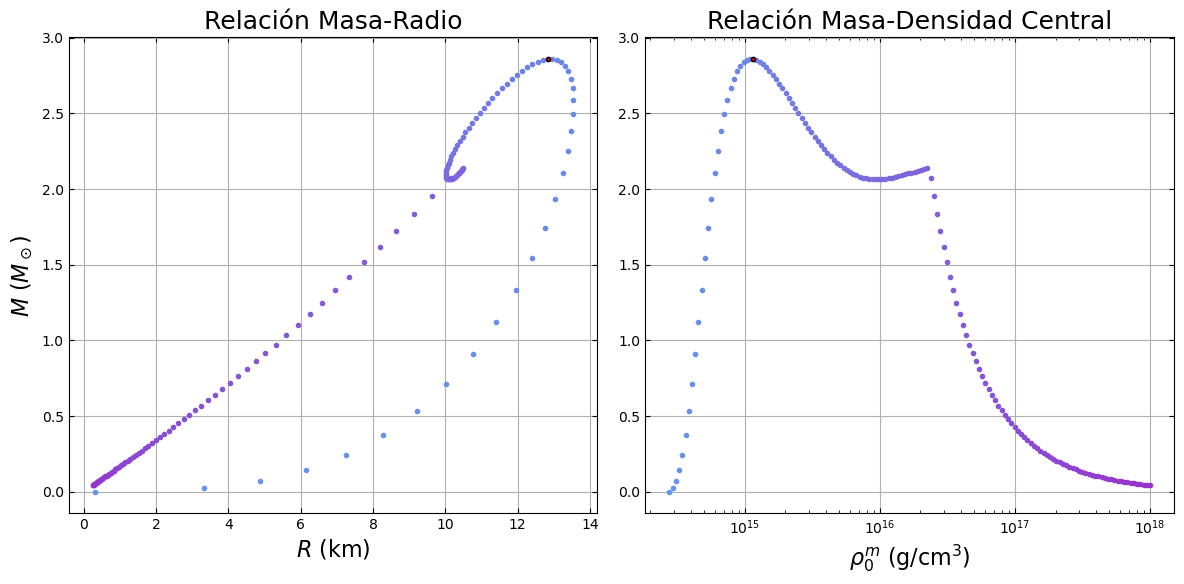

In [ ]:
# Definimos el espacio de densidades centrales de masa para la integración
rhos_masa = np.logspace(np.log10(2.77e14), 18, 150) # Densidades de masa en kg/m^3 (desde donde es util la EoS)
# rhos_masa = np.logspace(14, 18, 100) # Densidades de masa en kg/m^3

# Calculamos la densidad de energía asociada a cada densidad de masa
rhos = []
for rho_m in rhos_masa:
    densidad_energia, _ = energia_presion(rho_m*1e3/m_nuc_MKS, A_sigma, A_omega, 1)
    rhos.append(densidad_energia)
    
# Definimos arrays para la masa y el radio
masas = np.zeros(len(rhos))
radios = np.zeros(len(rhos))

# Resolvemos el sistema TOV para cada densidad central de masa
arg_max = 0
for i in range(len(rhos)):
    rho0 = rhos[i] # Densidad de energía central en unidades geométricas
    R = rho_0_lambda/rho0 # Factor de conversión para la interpolación adimensionalizada con rho0
    rho_P_prima = lambda P: R*rho_P(P/R) # Interpolación adimensionalizada con rho0 (en función de P adimensional con rho0)
    P_central_prima = R*P_rho(1/R) # Presión central adimensionalizada con rho0
    densidad_limite_prima = R*densidad_limite # Densidad de energía límite adimensionalizada con rho0
    sol_final = tov.integrador(rf, dr, rho0*rho_geoToMKS, rho_P_prima, P_central_prima, densidad_limite=densidad_limite_prima)
    radios[i] = sol_final[0] # Radio final en metros
    masas[i] = sol_final[1] # Masa final en kg
    if masas[i] > masas[arg_max]:
        arg_max = i
    # print("Se pudo para densidad de masa =", format(rho_m,"2.2e"), "g/cm^3")
    
# Graficamos la relación masa-radio
tov.grafica_masa_radio(radios, masas, rhos_masa)

### Estrella con la masa máxima

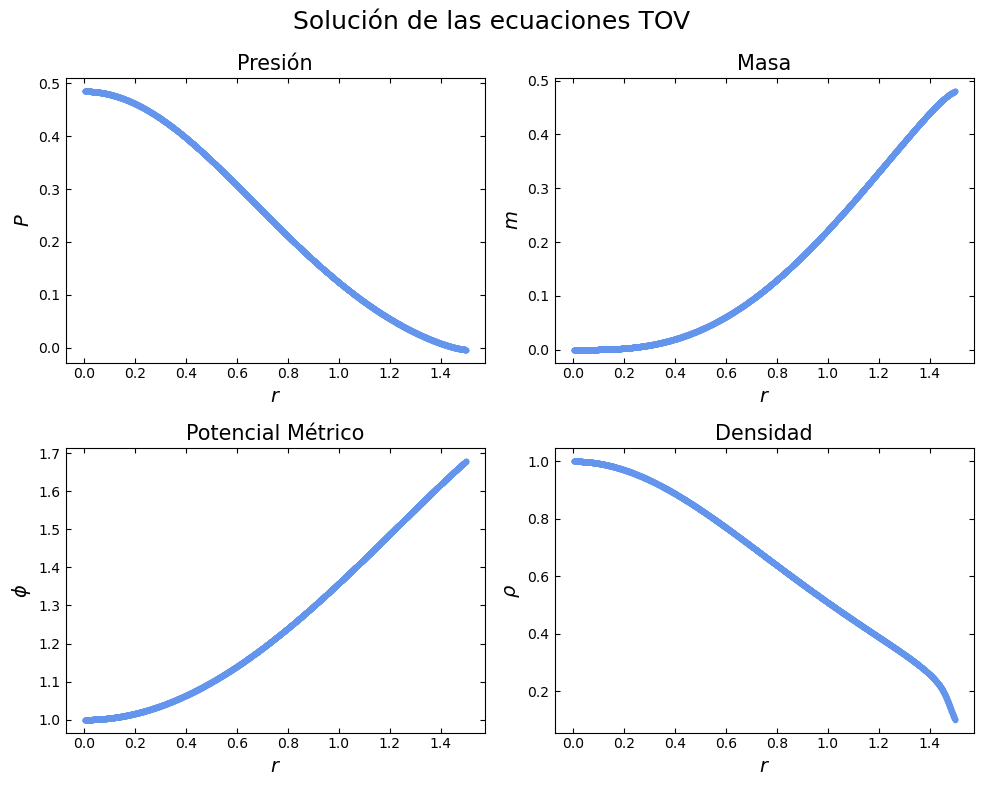

In [ ]:
# Graficamos la solucion con masa máxima
rho0 = rhos[arg_max] # Densidad de energía central en unidades geométricas
# rho0, _ = energia_presion(2e16*1e3/m_nuc_MKS, A_sigma, A_omega, 1)
R = rho_0_lambda/rho0 # Factor de conversión para la interpolación adimensionalizada con rho0
rho_P_prima = lambda P: R*rho_P(P/R) # Interpolación adimensionalizada con rho0 (en función de P adimensional con rho0)
P_central_prima = R*P_rho(1/R) # Presión central adimensionalizada con rho0
densidad_limite_prima = R*densidad_limite # Densidad de energía límite adimensionalizada con rho0
sol_final = tov.integrador(rf, dr, rho0*rho_geoToMKS, rho_P_prima, P_central_prima)
tov.graficar_solucion(rf, dr, rho0*rho_geoToMKS, rho_P_prima, P_central_prima, densidad_limite=0.1)

## Resultados de la EoS

Visualizamos los resultados de los métodos anteriores

#### Autoconsistencia

x_sigma = 0.007276580872271121 m , x_sigma = 1.2330774736147544e-54 , para n_barion = 5.978637491234571e+46 m^-3, autoconsistencia($\tilde{x}_\sigma$) = -3.3306690738754696e-16


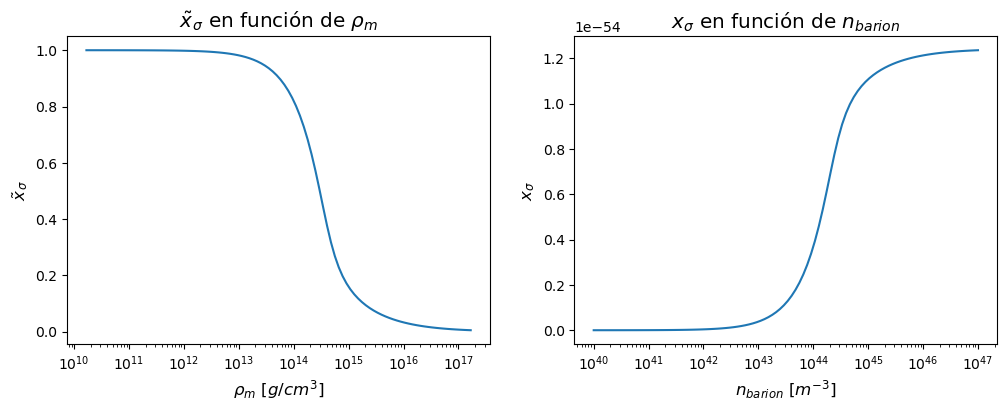

In [48]:
# Autoconsistencia
n_barion_max = 1e17*1e3/m_nuc_MKS # 1e17 g/cm^3 de bariones en unidades de m^-3
x_sigma = sol_x_sigma(n_barion_max, A_sigma)
x_sigma_norm = (1-x_sigma)*m_nuc # x_sigma no tilde
print("x_sigma =", x_sigma, "m , x_sigma =", x_sigma_norm, ", para n_barion =", n_barion_max, r"m^-3, autoconsistencia($\tilde{x}_\sigma$) =", autoconsistencia(x_sigma, A_sigma, n_barion_max))

# Testeamos la solucion_x_sigma
n_prove = np.logspace(40, 47, 100)
x_sigma_prove_tilde = np.zeros(len(n_prove))
x_sigma_prove = np.zeros(len(n_prove))
for i in range(len(n_prove)):
    x_sigma_prove_tilde[i] = sol_x_sigma(n_prove[i], A_sigma)
    x_sigma_prove[i] = (1-x_sigma_prove_tilde[i])*m_nuc

# Mostramos los resultados para x_sigma y x_sigma en función de n_barion
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(n_prove*m_nuc_MKS*1e-3, x_sigma_prove_tilde)
ax[0].set_xscale('log')
ax[0].set_xlabel(r'$\rho_m$ $[g/cm^3]$')
ax[0].set_ylabel(r'$\tilde x_{\sigma}$')
ax[0].set_title(r'$\tilde x_{\sigma}$ en función de $\rho_m$')
ax[1].plot(n_prove, x_sigma_prove)
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$n_{barion}$ $[m^{-3}]$')
ax[1].set_ylabel(r'$x_{\sigma}$')
ax[1].set_title(r'$x_{\sigma}$ en función de $n_{barion}$')
plt.show()

#### Valores de  $\frac{B}{A}$ vs $n_{barion}$

Densidad de saturación n_saturacion = 0.161 1/fm^3 y energia de enlace por nucleon en saturación = -16.240 MeV y densidad de energia en saturación = 148.220 MeV/fm^3


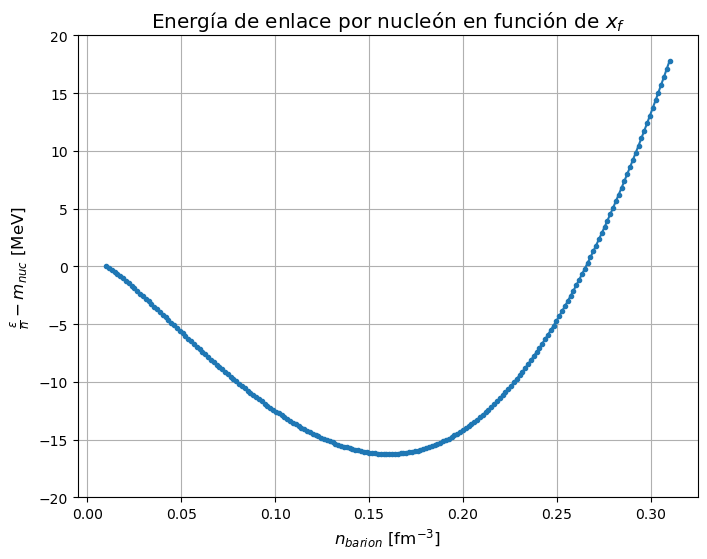

In [4]:
# Graficamos la energia de enlace por nucleon vs el parametro x_f
# densidades_prove = np.linspace(1e13, 6.5e14, 200) # Densidades de bariones en g/cm^3
# n_prove = densidades_prove*1e3/m_nuc_MKS # Densidades de bariones en m^-3
n_prove = np.linspace(0.01, 0.31, 200)*1e45 # Densidades de bariones de fm^-3 a m^-3
energias_prove = np.zeros(len(n_prove)) # Energías de enlace por nucleón en m^-2 (geometrizadas)
x_f_prove = np.zeros(len(n_prove)) # Momentos de Fermi adimensional
for i in range(len(n_prove)):
    energias_prove[i], _, x_f_prove[i] = energia_presion(n_prove[i], A_sigma, A_omega, 1, True)
    
# Hallamos la densidad de saturación en fm^-3 a partir del x_f donde es minima la energía de enlace por nucleón
e_MKS = 1.6021766e-19 # J
minimo = np.argmin(energias_prove/n_prove - m_nuc)
n_saturacion = n_prove[minimo] # Densidad de saturación en m^-3
n_saturacion *= (1e-15)**3 # Densidad de saturación en fm^-3
print("Densidad de saturación n_saturacion =", format(n_saturacion,".3f"), "1/fm^3 y energia de enlace por nucleon en saturación =", format((np.min(energias_prove/n_prove - m_nuc))*c_MKS**4/G_MKS/e_MKS*1e-6, ".3f"), "MeV y densidad de energia en saturación =", format(energias_prove[minimo]*c_MKS**4/G_MKS/e_MKS*1e-6*(1e-15)**3, ".3f"), "MeV/fm^3")
    
# Graficamos la energía de enlace por nucleón en función de x_f
plt.figure(figsize=(8,6))
plt.plot(n_prove*(1e-15)**3, (energias_prove/n_prove - m_nuc)*c_MKS**4/G_MKS/e_MKS*1e-6, "-o")
plt.xlabel(r'$n_{barion}$ [fm$^{-3}$]')
plt.ylabel(r'$\frac{\epsilon}{n}-m_{nuc}$ [MeV]')
plt.ylim(-20, 20)
plt.title(r'Energía de enlace por nucleón en función de $x_f$')
plt.grid()
plt.show()

#### Estimación de los parámetros A_sigma y A_omega

  - Verificamos como cambian $\frac{B}{A}$ y $n_{barion}$ al variar $A_{\sigma}$ y $A_{\omega}$

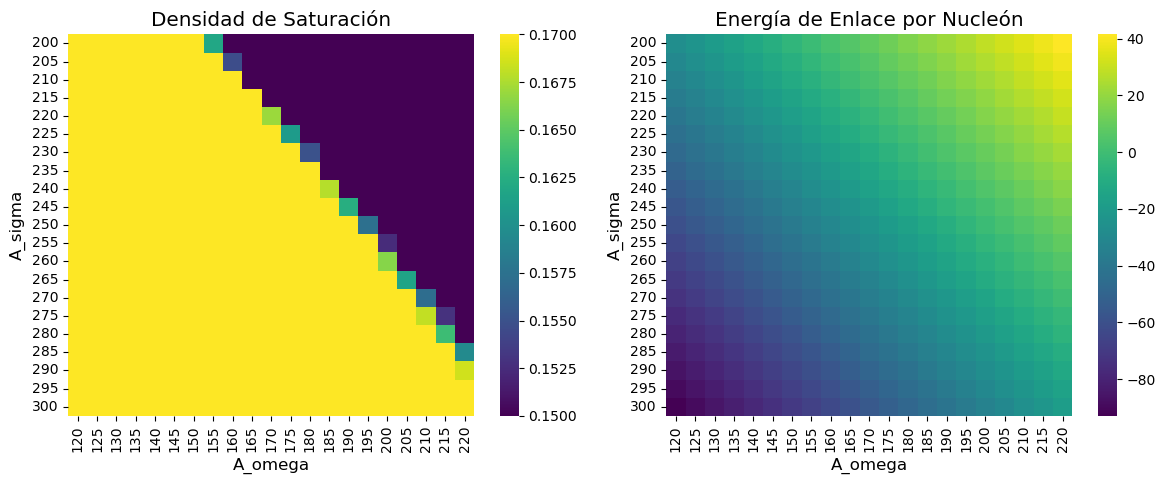

In [ ]:
import seaborn as sns

# Definimos los rangos de A_sigma y A_omega a probar
A_sigma_values = np.arange(200, 301, 5)
A_omega_values = np.arange(120, 221, 5)

# Inicializamos matrices para guardar los resultados
n_saturacion_matrix = np.zeros((len(A_sigma_values), len(A_omega_values)))
energia_por_nucleon_matrix = np.zeros((len(A_sigma_values), len(A_omega_values)))
n_saturacion_prove = np.linspace(0.15,0.17, 100)*(1e15)**3 # Densidades de saturación en m^-3
n_deseado = 0.161 # n_sat deseada en fm^-3
e_n_deseado = -16.24 # B/A deseada en MeV
precision_n = 0.005# Precisión n_sat en fm^-3
precision_e = 0.1 # Precisión B/A en MeV
e_MKS = 1.6021766e-19 # J

# Loop sobre los valores de A_sigma y A_omega
for i, A_sigma in enumerate(A_sigma_values):
    for j, A_omega in enumerate(A_omega_values):
        # Calculamos la energía de enlace por nucleón en saturación
        energias_prove = np.zeros(len(n_saturacion_prove))
        for k in range(len(n_saturacion_prove)):
            n_saturacion = n_saturacion_prove[k] # Densidad de saturación en m^-3
            energias_prove[k], _ = energia_presion(n_saturacion, A_sigma, A_omega, 1)
        
        # Hallamos el mínimo de la energía de enlace por nucleón en saturación
        minimo = np.argmin(energias_prove/n_saturacion_prove - m_nuc)
        n_saturacion = n_saturacion_prove[minimo]*(1e-15)**3 # Densidad de saturación en fm^-3
        energia_por_nucleon = (energias_prove[minimo]/n_saturacion_prove[minimo] - m_nuc) * c_MKS**4 / G_MKS / e_MKS * 1e-6 # Energía de enlace por nucleón en MeV
        
        # Guardamos los resultados en las matrices
        n_saturacion_matrix[i, j] = n_saturacion # Densidad de saturación en fm^-3
        energia_por_nucleon_matrix[i, j] = energia_por_nucleon # Energía de enlace por nucleón en MeV
        
        # Verificamos si alguna cumple ambas condiciones
        if np.abs(n_saturacion - n_deseado) < precision_n and np.abs(energia_por_nucleon - e_n_deseado) < precision_e:
            print(f"Se encontró una solución con A_sigma = {A_sigma}, A_omega = {A_omega} por ambas")
            print(f"Densidad de saturación = {n_saturacion:.3f} 1/fm^3")
            print(f"Energía de enlace por nucleón = {energia_por_nucleon:.3f} MeV")
            print("Bingo!")
            print()

# Ahora puedes usar las matrices para crear un heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(n_saturacion_matrix, xticklabels=A_omega_values, yticklabels=A_sigma_values, cmap="viridis", ax=ax1)
ax1.set_xlabel('A_omega')
ax1.set_ylabel('A_sigma')
ax1.set_title('Densidad de Saturación')
sns.heatmap(energia_por_nucleon_matrix, xticklabels=A_omega_values, yticklabels=A_sigma_values, cmap="viridis", ax=ax2)
ax2.set_xlabel('A_omega')
ax2.set_ylabel('A_sigma')
ax2.set_title('Energía de Enlace por Nucleón')
plt.tight_layout()
plt.show()

- Minimizamos el error de $\frac{B}{A}$ vs $n_{barion}$ para optimizar $A_{\sigma}$ y $A_{\omega}$

In [29]:
from scipy.optimize import minimize

# Definimos los valores deseados
n_deseado = 0.161 # n_sat deseada en fm^-3
e_n_deseado = -16.24 # B/A deseada en MeV
precision_n = 0.005 # Precisión n_sat en fm^-3
precision_e = 0.05 # Precisión B/A en MeV
# error_tol = (precision_e/e_n_deseado)**2 + (precision_n/n_deseado)**2 # Tolerancia del error
e_MKS = 1.6021766e-19 # J
n_saturacion_prove = np.linspace(0.15,0.17, 100)*(1e45) # Densidades de saturación en m^-3

# Definimos la función de error
def funcion_error_A(params):
    A_sigma, A_omega = params
    energias_prove = np.zeros(len(n_saturacion_prove))
    for k in range(len(n_saturacion_prove)):
        n_calc = n_saturacion_prove[k] # Densidad de saturación en m^-3
        energias_prove[k], _ = energia_presion(n_calc, A_sigma, A_omega, 1)
    
    # Hallamos el mínimo de la energía de enlace por nucleón en saturación
    minimo = np.argmin(energias_prove/n_saturacion_prove - m_nuc)
    n_saturacion = n_saturacion_prove[minimo]*(1e-45) # Densidad de saturación en fm^-3
    energia_por_nucleon = (energias_prove[minimo]/n_saturacion_prove[minimo] - m_nuc) * c_MKS**4 / G_MKS / e_MKS * 1e-6 # Energía de enlace por nucleón en MeV
    
    # Calculamos el error
    error_n = (n_saturacion - n_deseado)**2/n_deseado**2
    error_e = (energia_por_nucleon - e_n_deseado)**2/e_n_deseado**2
    return error_n + error_e


# Valores iniciales para A_sigma y A_omega
guess_inicial = [285, 300]

# Realizamos la minimización
result = minimize(funcion_error_A, guess_inicial, method='BFGS', tol=1e-6)

# Obtenemos los valores óptimos de A_sigma y A_omega
A_sigma_opt, A_omega_opt = result.x
error_opt = result.fun
print(f"Valores óptimos encontrados: A_sigma = {A_sigma_opt}, A_omega = {A_omega_opt}, error = {error_opt}")

# Calculamos la energía de enlace por nucleón y la densidad de saturación con los valores óptimos
energias_prove = np.zeros(len(n_saturacion_prove))
for k in range(len(n_saturacion_prove)):
    n_saturacion = n_saturacion_prove[k] # Densidad de saturación en m^-3
    energias_prove[k], _ = energia_presion(n_saturacion, A_sigma_opt, A_omega_opt, 1)

minimo = np.argmin(energias_prove/n_saturacion_prove - m_nuc)
n_saturacion_opt = n_saturacion_prove[minimo]*(1e-15)**3 # Densidad de saturación en fm^-3
energia_por_nucleon_opt = (energias_prove[minimo]/n_saturacion_prove[minimo] - m_nuc) * c_MKS**4 / G_MKS / e_MKS * 1e-6 # Energía de enlace por nucleón en MeV

print(f"Densidad de saturación óptima = {n_saturacion_opt:.3f} 1/fm^3")
print(f"Energía de enlace por nucleón óptima = {energia_por_nucleon_opt:.3f} MeV")


Valores óptimos encontrados: A_sigma = 330.26277839142386, A_omega = 249.5467233096414, error = 9.450915318270914e-06
Densidad de saturación óptima = 0.161 1/fm^3
Energía de enlace por nucleón óptima = -16.240 MeV


#### Interpolación de la ecuación de estado

In [40]:
# Calculamos la presion a 1e14 g/cm3
n_barion = 1e14*1e3/m_nuc_MKS
_, presion = energia_presion(n_barion, A_sigma_opt, A_omega_opt, 1)
print("Presión a 1e14 g/cm^3 =", format(presion, "2.2e"))

Presión a 1e14 g/cm^3 = -7.05e-13


Densidad central =  6.676657290559714e-08 para n_barion =  6.491248627298501e+45 y en g/cm^3 = 1.09e+16
Primera densida util 1.66e+44 1/m^3 por ende densidad de masa 2.77e+14 g/cm^3


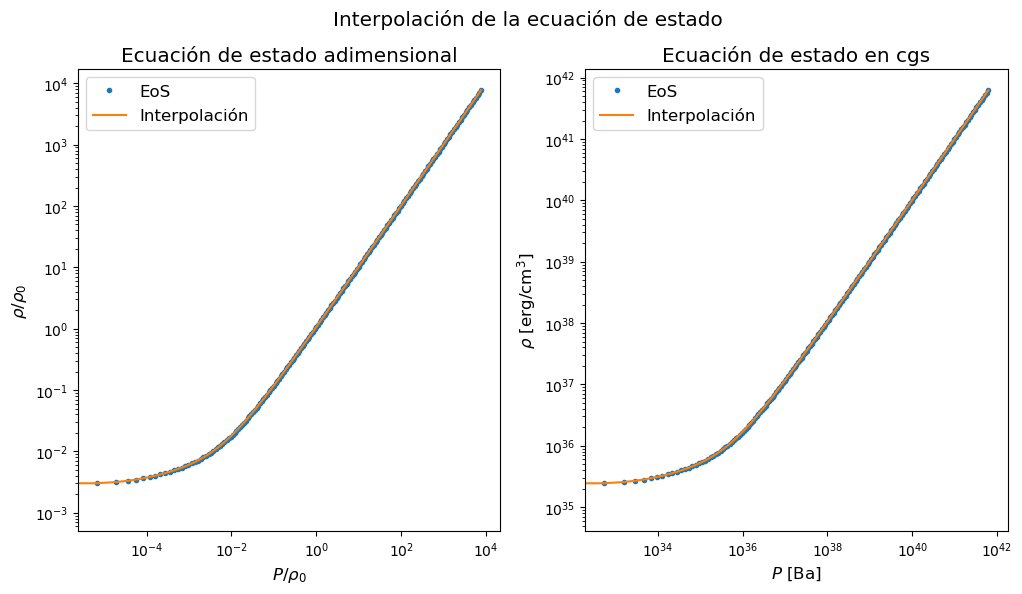

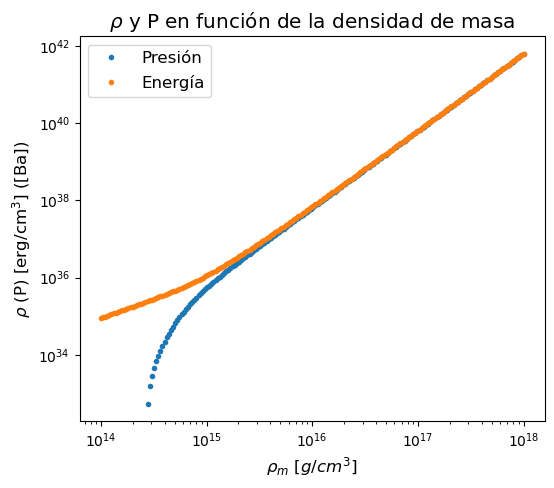

In [41]:
# Definimos el rango de densidades de bariones para la interpolación
densidad_masa_max = 1e18*1e3 # g/cm^3 a kg/m^3
densidad_masa_min = 1e14*1e3 # g/cm^3 a kg/m^3
n_barion_max = densidad_masa_max/m_nuc_MKS # m^-3
n_barion_min = densidad_masa_min/m_nuc_MKS # m^-3
n_barions = np.logspace(np.log10(n_barion_min), np.log10(n_barion_max), 200)

# Tomamos un valor de rho_0 para la interpolación
lambda_ = m_nuc**4/hbar**3 # Constante de escala empleada
rho_0_lambda = lambda_/2.0 # lambda_/(2*rho_0) = 1
# print("Densidad central = ", rho_0, "para n_barion_max = ", n_barion_max)

# Hallamos a que densidad de bariones corresponde este valor de rho_0
energias_inv, _, _, n_sirve, _ = EoS(n_barions, A_sigma, A_omega, rho_0_lambda, funcion_return='energia_inv')
n_0 = energias_inv(1)
print("Densidad central = ", rho_0_lambda, "para n_barion = ", n_0, "y en g/cm^3 =", format(n_0*m_nuc_MKS*1e-3,"2.2e"))

# Interpolamos la ecuación de estado
rho_P, presiones, energias, n_sirve, presion_cambio = EoS(n_barions, A_sigma, A_omega, rho_0_lambda, return_presion_cambio=True)
print("Primera densida util", "{:2.2e}".format(n_sirve[presion_cambio]), "1/m^3 por ende densidad de masa", format(n_sirve[presion_cambio]*m_nuc_MKS*1e-3,"2.2e"), "g/cm^3")

# Graficamos la ecuación de estado rho(P)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#Adimensional
ax1.loglog(presiones, energias, "o", label='EoS')
ax1.loglog(presiones, rho_P(presiones), label='Interpolación')
ax1.set_xlabel(r'$P/\rho_0$')
ax1.set_ylabel(r'$\rho/\rho_0$')
ax1.set_title('Ecuación de estado adimensional')
ax1.legend()

#cgs
rho_geoToMKS = c_MKS**4/G_MKS # factor de conversión de densidad de energía y presión de unidades geométricas a MKS
rho_MKSTocgs = 10 # factor de conversión de densidad de energía y presión de unidades MKS a cgs
ax2.loglog(presiones*rho_0_lambda*rho_geoToMKS*rho_MKSTocgs, energias*rho_0_lambda*rho_geoToMKS*rho_MKSTocgs, "o", label='EoS')
ax2.loglog(presiones*rho_0_lambda*rho_geoToMKS*rho_MKSTocgs, rho_P(presiones)*rho_0_lambda*rho_geoToMKS*rho_MKSTocgs, label='Interpolación')
ax2.set_xlabel(r'$P$ [Ba]')
ax2.set_ylabel(r'$\rho$ [erg/cm$^3$]')
ax2.set_title('Ecuación de estado en cgs')
ax2.legend()

plt.suptitle('Interpolación de la ecuación de estado')
plt.show()

# Graficamos presión y energía en función de n_barion
plt.figure(figsize=(6, 5))
plt.loglog(n_sirve*m_nuc_MKS*1e-3, presiones*rho_0_lambda*rho_geoToMKS*rho_MKSTocgs, "o", label='Presión')
plt.loglog(n_sirve*m_nuc_MKS*1e-3, energias*rho_0_lambda*rho_geoToMKS*rho_MKSTocgs, "o", label='Energía')
plt.xlabel(r'$\rho_m$ $[g/cm^3]$')
plt.ylabel(r'$\rho$ (P) [erg/cm$^3$] ([Ba])')
plt.title(r'$\rho$ y P en función de la densidad de masa')
plt.legend()
plt.show()

#### Comparación entre diferentes $\rho_0$

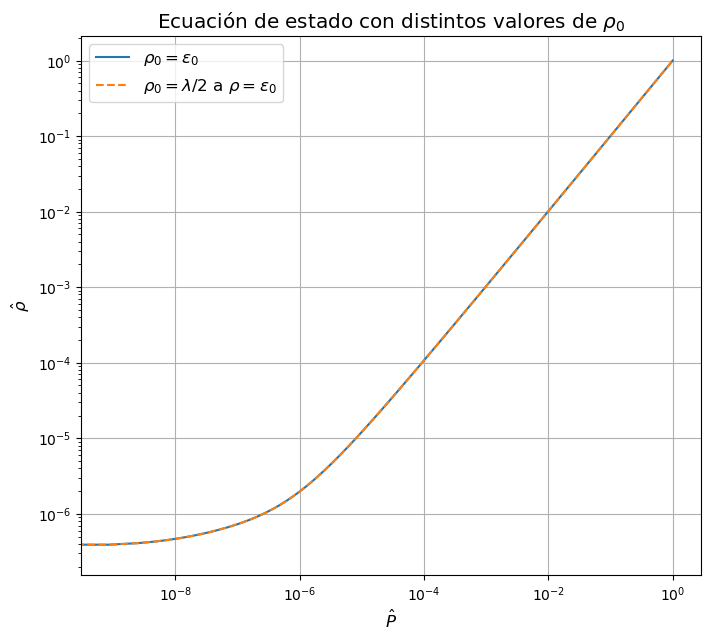

In [35]:
# Hallamos la densidad de energia central para n_max
ee_0, _ = energia_presion(n_barion_max, A_sigma, A_omega, 1)

# Obtenemos una interpolacion con rho_0 = ee_0 y otra con rho_0 = lambda/2 para comparar
rho_P_0, presiones_0, energias_0, _, _ = EoS(n_barions, A_sigma, A_omega, ee_0, return_presion_cambio=True)
rho_P_lambda, presiones_lambda, energias_lambda, _, _ = EoS(n_barions, A_sigma, A_omega, lambda_/2, return_presion_cambio=True)

# Graficamos la ecuación de estado con distintos valores de rho_0
plt.figure(figsize=(8, 7))
# plt.plot(presiones, rho_P(presiones), label=r'$\rho_0 = \lambda/2$')
plt.loglog(presiones_0, rho_P_0(presiones_0), '-', label=r'$\rho_0 = \epsilon_0$')
plt.loglog(presiones_lambda*lambda_/2/ee_0, rho_P_lambda(presiones_lambda)*lambda_/2/ee_0, '--', label=r'$\rho_0 = \lambda/2$ a $\rho = \epsilon_0$')
# plt.loglog(presiones_lambda*lambda_/2/ee_0, rho_P_lambda(presiones_lambda)*lambda_/2/ee_0, 'o', label=r'$\rho_0 = \epsilon_0$ mult')
# plt.xlabel(r'$P/\rho_0$')
plt.xlabel(r'$\hat P$')
# plt.ylabel(r'$\rho/\rho_0$')
plt.ylabel(r'$\hat\rho$')
plt.title(r'Ecuación de estado con distintos valores de $\rho_0$')
plt.grid()
plt.legend()
plt.show()